In [1]:
import glob
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from uncertainties import ufloat, unumpy

from lmfit.models import Model, ConstantModel, LinearModel, PolynomialModel, GaussianModel, VoigtModel, LorentzianModel, PseudoVoigtModel, DonaichModel

sns.set_context('talk')

In [2]:
## To use LaTeX and select Helvetica as the default font, without editing matplotlibrc use:
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

#plt.rc('text', usetex=True)
#plt.rc('text.latex', preamble=r'\usepackage{physics}')
#plt.rc('font', family='serif')

In [3]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})

#params = {'text.latex.preamble':[r'\usepackage{siunitx}',
#                                 r'\usepackage{amsmath}',
#                                 r'\usepackage{physics}',
#                                 r'\usepackage{sfmath}',
#                                 r'\sisetup{detect-all=true}']}

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}']}
plt.rcParams.update(params)

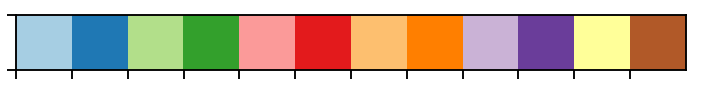

In [4]:
sns.palplot(sns.color_palette("Paired"))

# MCP saturation varying UV power

### Read in UV calibration DAQ voltages

In [5]:
UV_PD_DAQ_data = pd.read_excel(os.path.join('UV_PD_DAQ_check', 'UV_PD_DAQ_check.xlsx'))

### Fitting the UV calibration DAQ voltages to the measured UV power

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 10
    # variables        = 2
    chi-square         = 1.33302305
    reduced chi-square = 0.16662788
    Akaike info crit   = -16.1513576
    Bayesian info crit = -15.5461874
[[Variables]]
    intercept:  0.00599894 +/- 0.24202351 (4034.44%) (init = 0)
    slope:      9.75045048 +/- 0.08331620 (0.85%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(intercept, slope) = -0.846



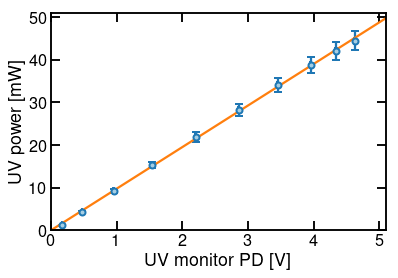

In [6]:
# Set data
x = UV_PD_DAQ_data['UV_Power (avg.) [V]']
xerr = UV_PD_DAQ_data['UV_Power (std.) [V]']
y = UV_PD_DAQ_data['UV_Power (avg.) [mW]']
yerr = UV_PD_DAQ_data['UV_Power (std.) [mW]']

# Specify fit model
fit_model = LinearModel()
fit_params = fit_model.make_params()

# Set initial guesses
fit_params['intercept'].set(0)
fit_params['slope'].set(10)

# Initial guess
xfit = xfit = np.linspace(-1, 10, num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(y, fit_params, x=x)
dely = fit_result.eval_uncertainty(x=x)
yfit = fit_model.eval(fit_result.params, x=xfit)
print(fit_result.fit_report())

plt.figure()
# Plot data
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=4, markeredgewidth=2, markersize=6,
             markeredgecolor=sns.color_palette("Paired")[1], markerfacecolor=sns.color_palette("Paired")[0])

# Plot initial guess
#plt.plot(xfit, yinit)

# Plot fitted result
plt.plot(xfit, yfit)

plt.gca().tick_params(direction='in', axis='both', bottom=True, top=True, left=True, right=True)

plt.xlim(0, 5.1)
plt.ylim(0, 51)

plt.xlabel('UV monitor PD [V]')
plt.ylabel('UV power [mW]')
plt.show()

In [7]:
# Save fitted slope and intercept for later use
conversion_slope = ufloat(fit_result.params['slope'].value, fit_result.params['slope'].stderr)
conversion_intercept = ufloat(fit_result.params['intercept'].value, fit_result.params['intercept'].stderr)

## Plotting the fitted peak heights from spectra varying UV power

### Read in the .csv files and fit to extract maximum peak height

In [8]:
spectra_list = glob.glob(os.path.join('vary_uv_power', 'scan_UV_VCA-n33-pol_atomic_line*_out.csv'))

# Read in the individual .csv files and add them to the larger DataFrame
vary_UV_data = pd.DataFrame()
for f in spectra_list:
    temp = pd.read_csv(f)
    temp['Scan'] = f
    
    # Get UV_VCA set point voltage from file name
    temp['UV_VCA [V]'] = float(os.path.basename(f).split('UV_VCA-')[-1].split('_')[0])
    
    temp['Timestamp'] = pd.to_datetime(temp['Timestamp'])
    
    vary_UV_data = pd.concat([vary_UV_data, temp], join='outer', ignore_index=True)

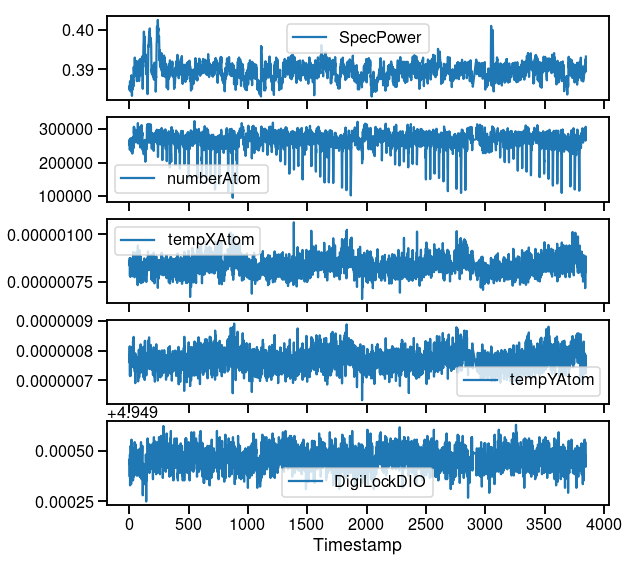

In [30]:
[fig, axs] = plt.subplots(nrows=5, sharex=True, figsize=(9,9))

axs[0].plot(vary_UV_data['Spec_Power'], label=r'SpecPower')
axs[1].plot(vary_UV_data['numberAtom'], label=r'numberAtom')
axs[2].plot(vary_UV_data['tempXAtom'], label=r'tempXAtom')
axs[3].plot(vary_UV_data['tempYAtom'], label=r'tempYAtom')
axs[4].plot(vary_UV_data['DigiLock_PID1_locked'], label=r'DigiLockDIO')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()
plt.xlabel(r'Timestamp')

plt.show()

### Weed out 'bad' data points

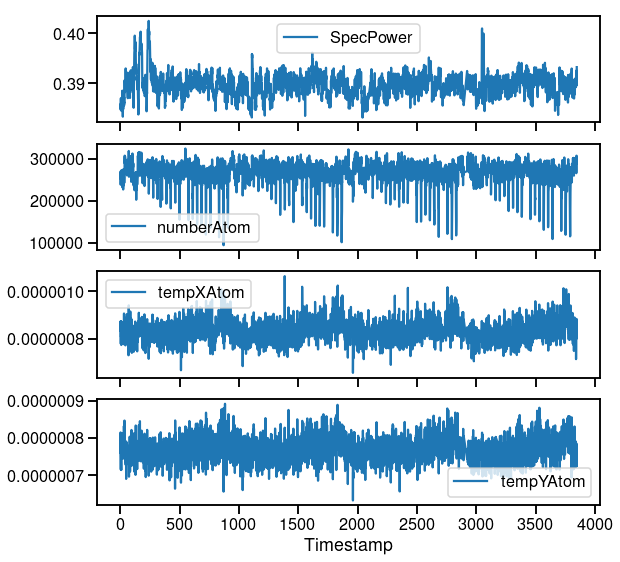

In [32]:
vary_UV_data = vary_UV_data[vary_UV_data['DigiLock_PID1_locked'] > 4.9]
vary_UV_data = vary_UV_data[(0.6E-6 <= vary_UV_data['tempYAtom']) & (vary_UV_data['tempYAtom'] <= 0.95E-6)]

[fig, axs] = plt.subplots(nrows=4, sharex=True, figsize=(9,9))
axs[0].plot(vary_UV_data['Spec_Power'], label=r'SpecPower')
axs[1].plot(vary_UV_data['numberAtom'], label=r'numberAtom')
axs[2].plot(vary_UV_data['tempXAtom'], label=r'tempXAtom')
axs[3].plot(vary_UV_data['tempYAtom'], label=r'tempYAtom')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
plt.xlabel(r'Timestamp')
plt.show()

### Fitting each spectra to extract peak heights

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 37
    # variables        = 4
    chi-square         = 162.147347
    reduced chi-square = 4.91355596
    Akaike info crit   = 62.6707396
    Bayesian info crit = 69.1144112
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.37559126 +/- 0.06303077 (16.78%) (init = 0.15)
    mF112_sigma:      0.06875010 +/- 0.00130090 (1.89%) (init = 0.02)
    mF112_center:     1507.66036 +/- 8.7203e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  25.4874635 +/- 0.54589771 (2.14%) (init = 149.25)
    mF112_fwhm:       0.13750020 +/- 0.00260180 (1.89%) == '2.0000000*mF112_sigma'
    mF112_height:     153.054617 +/- 2.07453116 (1.36%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are 

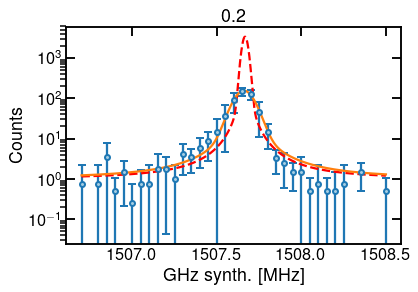

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 37
    # variables        = 4
    chi-square         = 1262.85240
    reduced chi-square = 38.2682546
    Akaike info crit   = 138.617783
    Bayesian info crit = 145.061454
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.27873291 +/- 0.03506809 (12.58%) (init = 0.15)
    mF112_sigma:      0.05631549 +/- 5.4581e-04 (0.97%) (init = 0.02)
    mF112_center:     1507.66616 +/- 3.5103e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  123.800822 +/- 1.41154003 (1.14%) (init = 874.5)
    mF112_fwhm:       0.11263097 +/- 0.00109162 (0.97%) == '2.0000000*mF112_sigma'
    mF112_height:     939.827382 +/- 6.56774886 (0.70%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are <

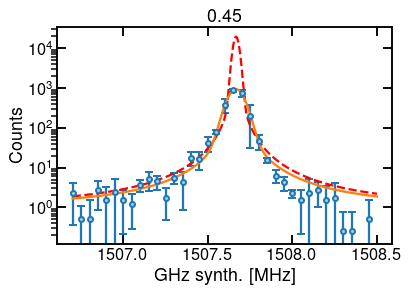

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 37
    # variables        = 4
    chi-square         = 15563.0010
    reduced chi-square = 471.606092
    Akaike info crit   = 231.544148
    Bayesian info crit = 237.987820
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.12764904 +/- 0.06746351 (52.85%) (init = 0.15)
    mF112_sigma:      0.06555784 +/- 0.00104085 (1.59%) (init = 0.02)
    mF112_center:     1507.66676 +/- 6.6693e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  246.785201 +/- 5.31604254 (2.15%) (init = 1607.25)
    mF112_fwhm:       0.13111567 +/- 0.00208170 (1.59%) == '2.0000000*mF112_sigma'
    mF112_height:     1695.44870 +/- 20.4870122 (1.21%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are

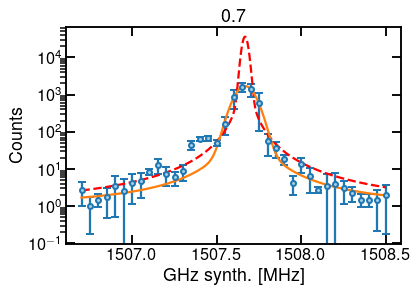

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 385
    # data points      = 37
    # variables        = 4
    chi-square         = 73431.0641
    reduced chi-square = 2225.18376
    Akaike info crit   = 288.947824
    Bayesian info crit = 295.391496
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.42510035 +/- 0.06819306 (16.04%) (init = 0.15)
    mF112_sigma:      0.05392649 +/- 0.00116933 (2.17%) (init = 0.02)
    mF112_center:     1507.68725 +/- 7.5880e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  448.560039 +/- 10.3612084 (2.31%) (init = 3270.5)
    mF112_fwhm:       0.10785297 +/- 0.00233866 (2.17%) == '2.0000000*mF112_sigma'
    mF112_height:     3371.73707 +/- 51.0478209 (1.51%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are

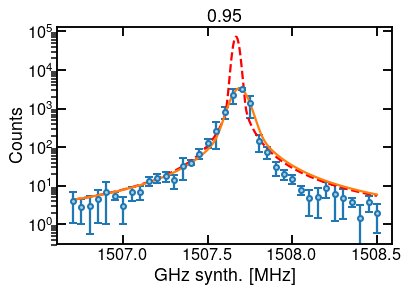

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 198
    # data points      = 37
    # variables        = 4
    chi-square         = 311593.936
    reduced chi-square = 9442.24047
    Akaike info crit   = 342.425914
    Bayesian info crit = 348.869586
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.99999999 +/- 0.14598388 (14.60%) (init = 0.15)
    mF112_sigma:      0.04109016 +/- 0.00301558 (7.34%) (init = 0.02)
    mF112_center:     1507.68794 +/- 0.00148688 (0.00%) (init = 1507.667)
    mF112_amplitude:  680.359223 +/- 18.8171393 (2.77%) (init = 4870.667)
    mF112_fwhm:       0.08218031 +/- 0.00603115 (7.34%) == '2.0000000*mF112_sigma'
    mF112_height:     5270.48532 +/- 787.364059 (14.94%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations 

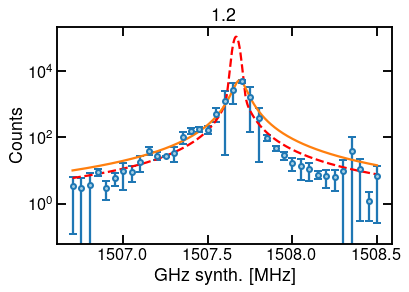

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 37
    # variables        = 4
    chi-square         = 821278.526
    reduced chi-square = 24887.2281
    Akaike info crit   = 378.284888
    Bayesian info crit = 384.728559
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.57770840 +/- 0.08851867 (15.32%) (init = 0.15)
    mF112_sigma:      0.05544247 +/- 0.00176455 (3.18%) (init = 0.02)
    mF112_center:     1507.65691 +/- 0.00123391 (0.00%) (init = 1507.667)
    mF112_amplitude:  1067.34249 +/- 34.3257410 (3.22%) (init = 7400.75)
    mF112_fwhm:       0.11088493 +/- 0.00352910 (3.18%) == '2.0000000*mF112_sigma'
    mF112_height:     7358.80137 +/- 160.763084 (2.18%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are

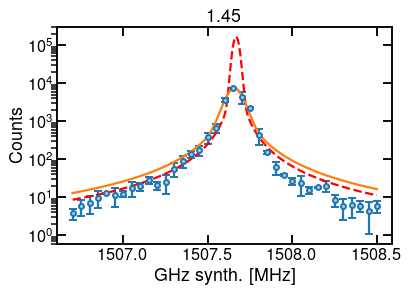

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 37
    # variables        = 4
    chi-square         = 974519.505
    reduced chi-square = 29530.8941
    Akaike info crit   = 384.614930
    Bayesian info crit = 391.058602
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.59917457 +/- 0.06970938 (11.63%) (init = 0.15)
    mF112_sigma:      0.05845691 +/- 0.00156379 (2.68%) (init = 0.02)
    mF112_center:     1507.63763 +/- 9.5727e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  1601.22383 +/- 38.9959157 (2.44%) (init = 10209)
    mF112_fwhm:       0.11691382 +/- 0.00312758 (2.68%) == '2.0000000*mF112_sigma'
    mF112_height:     10381.3425 +/- 182.993307 (1.76%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are <

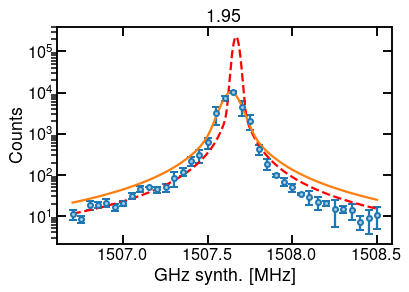

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 110
    # data points      = 37
    # variables        = 4
    chi-square         = 524229.929
    reduced chi-square = 15885.7554
    Akaike info crit   = 361.674407
    Bayesian info crit = 368.118078
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.57177043 +/- 0.04160446 (7.28%) (init = 0.15)
    mF112_sigma:      0.05623522 +/- 9.0275e-04 (1.61%) (init = 0.02)
    mF112_center:     1507.66733 +/- 4.8381e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  2081.17883 +/- 28.7128528 (1.38%) (init = 13314.25)
    mF112_fwhm:       0.11247044 +/- 0.00180550 (1.61%) == '2.0000000*mF112_sigma'
    mF112_height:     14179.7018 +/- 147.025723 (1.04%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

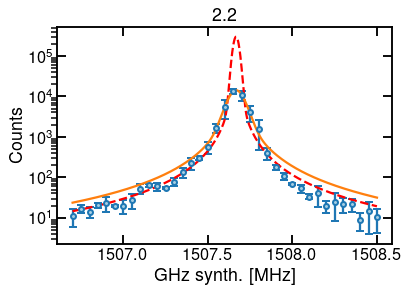

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 37
    # variables        = 4
    chi-square         = 5428845.08
    reduced chi-square = 164510.457
    Akaike info crit   = 448.163805
    Bayesian info crit = 454.607477
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.06550937 +/- 0.14885295 (227.22%) (init = 0.15)
    mF112_sigma:      0.07096890 +/- 0.00236181 (3.33%) (init = 0.02)
    mF112_center:     1507.65027 +/- 0.00172692 (0.00%) (init = 1507.667)
    mF112_amplitude:  2130.83468 +/- 101.395996 (4.76%) (init = 13092.25)
    mF112_fwhm:       0.14193780 +/- 0.00472361 (3.33%) == '2.0000000*mF112_sigma'
    mF112_height:     13805.4513 +/- 359.790753 (2.61%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations a

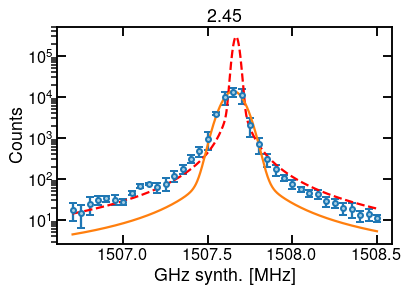

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 37
    # variables        = 4
    chi-square         = 2391030.60
    reduced chi-square = 72455.4728
    Akaike info crit   = 417.823734
    Bayesian info crit = 424.267406
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.87279565 +/- 0.10362287 (11.87%) (init = 0.15)
    mF112_sigma:      0.04281823 +/- 0.00342784 (8.01%) (init = 0.02)
    mF112_center:     1507.67109 +/- 6.9539e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  2750.68628 +/- 60.6189457 (2.20%) (init = 17549.75)
    mF112_fwhm:       0.08563646 +/- 0.00685568 (8.01%) == '2.0000000*mF112_sigma'
    mF112_height:     21685.8212 +/- 1058.03428 (4.88%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

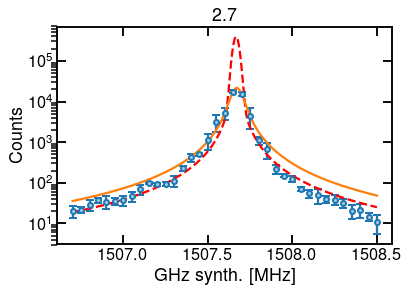

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 37
    # variables        = 4
    chi-square         = 2125673.27
    reduced chi-square = 64414.3416
    Akaike info crit   = 413.471206
    Bayesian info crit = 419.914877
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.43376767 +/- 0.06519758 (15.03%) (init = 0.15)
    mF112_sigma:      0.06783253 +/- 0.00142016 (2.09%) (init = 0.02)
    mF112_center:     1507.63180 +/- 8.9015e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  2863.39450 +/- 62.8674405 (2.20%) (init = 16232.25)
    mF112_fwhm:       0.13566505 +/- 0.00284032 (2.09%) == '2.0000000*mF112_sigma'
    mF112_height:     17055.7237 +/- 247.202401 (1.45%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

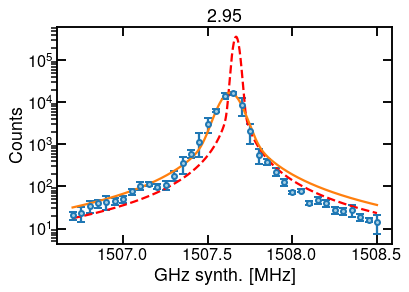

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 37
    # variables        = 4
    chi-square         = 3960589.50
    reduced chi-square = 120017.864
    Akaike info crit   = 436.496464
    Bayesian info crit = 442.940136
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.38701433 +/- 0.07368587 (19.04%) (init = 0.15)
    mF112_sigma:      0.06217575 +/- 0.00138760 (2.23%) (init = 0.02)
    mF112_center:     1507.65996 +/- 9.3878e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  3207.87243 +/- 80.8562552 (2.52%) (init = 20254.75)
    mF112_fwhm:       0.12435151 +/- 0.00277520 (2.23%) == '2.0000000*mF112_sigma'
    mF112_height:     21211.2364 +/- 339.187196 (1.60%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

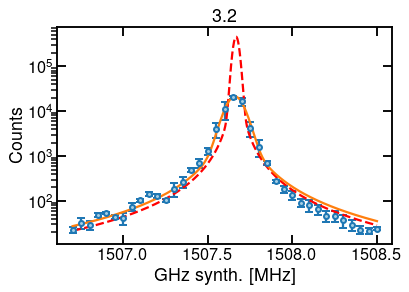

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 37
    # variables        = 4
    chi-square         = 3427237.26
    reduced chi-square = 103855.674
    Akaike info crit   = 431.144843
    Bayesian info crit = 437.588515
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.37289141 +/- 0.06897776 (18.50%) (init = 0.15)
    mF112_sigma:      0.07306868 +/- 0.00151141 (2.07%) (init = 0.02)
    mF112_center:     1507.63450 +/- 9.9216e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  3549.98226 +/- 82.4286885 (2.32%) (init = 20189.75)
    mF112_fwhm:       0.14613736 +/- 0.00302282 (2.07%) == '2.0000000*mF112_sigma'
    mF112_height:     20077.8810 +/- 295.591623 (1.47%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

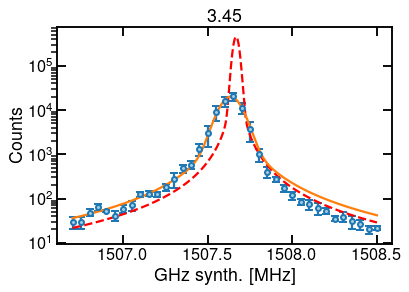

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 131
    # data points      = 37
    # variables        = 4
    chi-square         = 1913006.77
    reduced chi-square = 57969.9022
    Akaike info crit   = 409.570948
    Bayesian info crit = 416.014620
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.46982694 +/- 0.04236097 (9.02%) (init = 0.15)
    mF112_sigma:      0.06686734 +/- 9.4889e-04 (1.42%) (init = 0.02)
    mF112_center:     1507.67010 +/- 5.7712e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  4168.83314 +/- 59.3926182 (1.42%) (init = 23626.25)
    mF112_fwhm:       0.13373468 +/- 0.00189777 (1.42%) == '2.0000000*mF112_sigma'
    mF112_height:     24849.5727 +/- 239.936151 (0.97%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

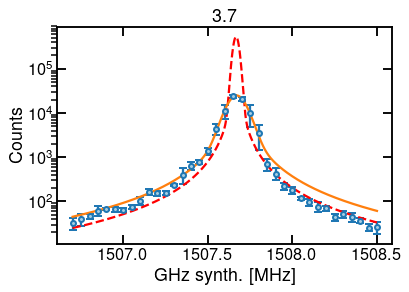

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 37
    # variables        = 4
    chi-square         = 1111498.81
    reduced chi-square = 33681.7821
    Akaike info crit   = 389.481175
    Bayesian info crit = 395.924847
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.66233051 +/- 0.03035629 (4.58%) (init = 0.15)
    mF112_sigma:      0.05548560 +/- 7.3127e-04 (1.32%) (init = 0.02)
    mF112_center:     1507.63247 +/- 3.6841e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  4165.79647 +/- 41.5226495 (1.00%) (init = 25800.5)
    mF112_fwhm:       0.11097121 +/- 0.00146254 (1.32%) == '2.0000000*mF112_sigma'
    mF112_height:     27736.8375 +/- 226.715283 (0.82%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are 

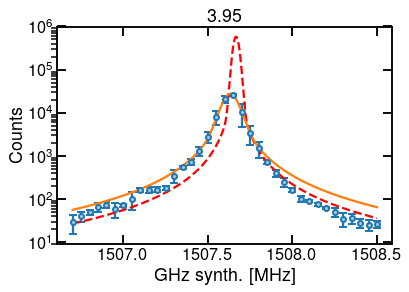

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 37
    # variables        = 4
    chi-square         = 7326144.67
    reduced chi-square = 222004.384
    Akaike info crit   = 459.253556
    Bayesian info crit = 465.697228
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.85150917 +/- 0.05845049 (6.86%) (init = 0.15)
    mF112_sigma:      0.05739202 +/- 0.00164212 (2.86%) (init = 0.02)
    mF112_center:     1507.65642 +/- 0.00106660 (0.00%) (init = 1507.667)
    mF112_amplitude:  4668.10068 +/- 104.277397 (2.23%) (init = 27487.5)
    mF112_fwhm:       0.11478404 +/- 0.00328424 (2.86%) == '2.0000000*mF112_sigma'
    mF112_height:     27719.0904 +/- 488.678785 (1.76%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are 

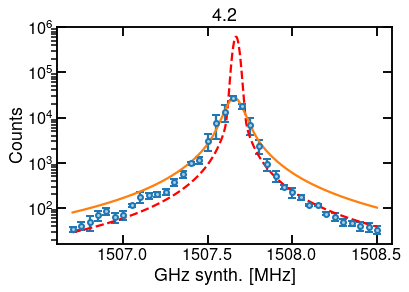

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 37
    # variables        = 4
    chi-square         = 613702.829
    reduced chi-square = 18597.0554
    Akaike info crit   = 367.504883
    Bayesian info crit = 373.948555
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.53561090 +/- 0.01980378 (3.70%) (init = 0.15)
    mF112_sigma:      0.06335380 +/- 4.4567e-04 (0.70%) (init = 0.02)
    mF112_center:     1507.63929 +/- 2.8512e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  4627.93971 +/- 32.0990010 (0.69%) (init = 27633)
    mF112_fwhm:       0.12670760 +/- 8.9134e-04 (0.70%) == '2.0000000*mF112_sigma'
    mF112_height:     28388.5308 +/- 135.809960 (0.48%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are < 

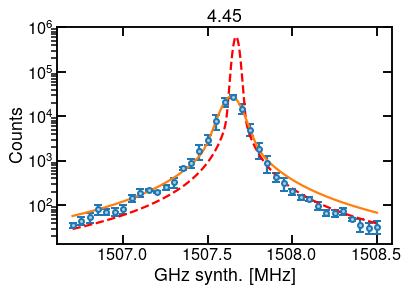

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 37
    # variables        = 4
    chi-square         = 18879402.8
    reduced chi-square = 572103.115
    Akaike info crit   = 494.278574
    Bayesian info crit = 500.722246
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.32975477 +/- 0.10708328 (32.47%) (init = 0.15)
    mF112_sigma:      0.07619715 +/- 0.00233920 (3.07%) (init = 0.02)
    mF112_center:     1507.67908 +/- 0.00154677 (0.00%) (init = 1507.667)
    mF112_amplitude:  5563.38498 +/- 198.374871 (3.57%) (init = 30761)
    mF112_fwhm:       0.15239430 +/- 0.00467841 (3.07%) == '2.0000000*mF112_sigma'
    mF112_height:     30650.2049 +/- 677.208760 (2.21%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are <

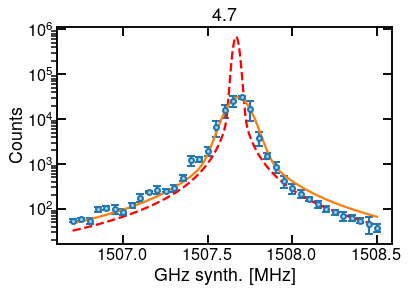

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 37
    # variables        = 4
    chi-square         = 20995598.8
    reduced chi-square = 636230.266
    Akaike info crit   = 498.209503
    Bayesian info crit = 504.653174
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.66276356 +/- 0.09567532 (14.44%) (init = 0.15)
    mF112_sigma:      0.06097530 +/- 0.00234729 (3.85%) (init = 0.02)
    mF112_center:     1507.65727 +/- 0.00152704 (0.00%) (init = 1507.667)
    mF112_amplitude:  5210.80385 +/- 182.301077 (3.50%) (init = 30803.25)
    mF112_fwhm:       0.12195059 +/- 0.00469458 (3.85%) == '2.0000000*mF112_sigma'
    mF112_height:     31565.5193 +/- 801.601698 (2.54%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

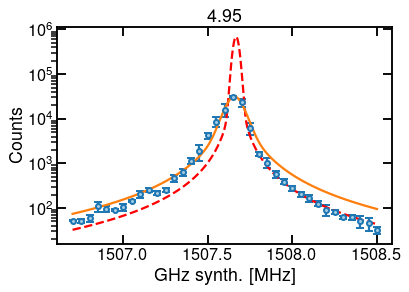

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 37
    # variables        = 4
    chi-square         = 10093836.9
    reduced chi-square = 305873.846
    Akaike info crit   = 471.111154
    Bayesian info crit = 477.554826
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.30033767 +/- 0.07235335 (24.09%) (init = 0.15)
    mF112_sigma:      0.07712392 +/- 0.00155238 (2.01%) (init = 0.02)
    mF112_center:     1507.65403 +/- 0.00106571 (0.00%) (init = 1507.667)
    mF112_amplitude:  5948.65611 +/- 144.296225 (2.43%) (init = 32136.25)
    mF112_fwhm:       0.15424784 +/- 0.00310475 (2.01%) == '2.0000000*mF112_sigma'
    mF112_height:     32722.4922 +/- 483.269872 (1.48%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

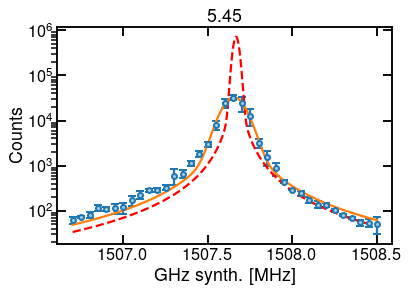

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 37
    # variables        = 4
    chi-square         = 7265587.86
    reduced chi-square = 220169.329
    Akaike info crit   = 458.946449
    Bayesian info crit = 465.390120
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.44388484 +/- 0.05646232 (12.72%) (init = 0.15)
    mF112_sigma:      0.07839716 +/- 0.00142649 (1.82%) (init = 0.02)
    mF112_center:     1507.65836 +/- 9.3247e-04 (0.00%) (init = 1507.667)
    mF112_amplitude:  6354.20084 +/- 123.376719 (1.94%) (init = 32455.75)
    mF112_fwhm:       0.15679432 +/- 0.00285298 (1.82%) == '2.0000000*mF112_sigma'
    mF112_height:     32624.0535 +/- 415.773784 (1.27%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

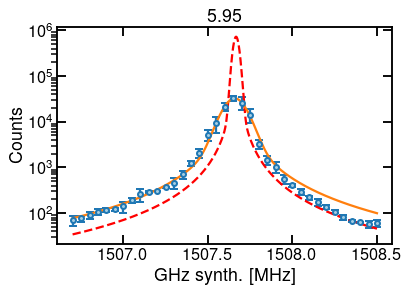

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 37
    # variables        = 4
    chi-square         = 35627701.8
    reduced chi-square = 1079627.33
    Akaike info crit   = 517.775496
    Bayesian info crit = 524.219168
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.37955510 +/- 0.11519673 (30.35%) (init = 0.15)
    mF112_sigma:      0.07760196 +/- 0.00269801 (3.48%) (init = 0.02)
    mF112_center:     1507.66815 +/- 0.00177309 (0.00%) (init = 1507.667)
    mF112_amplitude:  7065.94563 +/- 274.127606 (3.88%) (init = 36446.25)
    mF112_fwhm:       0.15520392 +/- 0.00539601 (3.48%) == '2.0000000*mF112_sigma'
    mF112_height:     37536.9504 +/- 926.349703 (2.47%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

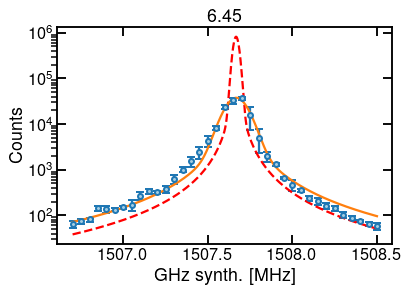

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 269
    # data points      = 37
    # variables        = 4
    chi-square         = 31769841.5
    reduced chi-square = 962722.469
    Akaike info crit   = 513.535074
    Bayesian info crit = 519.978746
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.65724684 +/- 0.09624909 (14.64%) (init = 0.15)
    mF112_sigma:      0.07553179 +/- 0.00299849 (3.97%) (init = 0.02)
    mF112_center:     1507.67776 +/- 0.00170480 (0.00%) (init = 1507.667)
    mF112_amplitude:  7636.52686 +/- 254.397773 (3.33%) (init = 37643.5)
    mF112_fwhm:       0.15106358 +/- 0.00599698 (3.97%) == '2.0000000*mF112_sigma'
    mF112_height:     37429.0855 +/- 946.976648 (2.53%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations ar

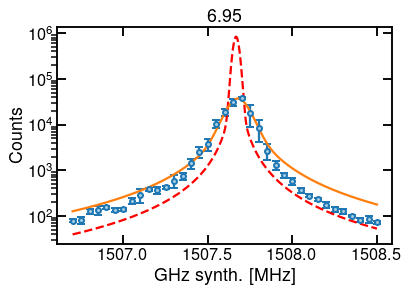

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 37
    # variables        = 4
    chi-square         = 19813389.5
    reduced chi-square = 600405.743
    Akaike info crit   = 496.065172
    Bayesian info crit = 502.508844
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.78257785 +/- 0.07252833 (9.27%) (init = 0.15)
    mF112_sigma:      0.06565663 +/- 0.00232949 (3.55%) (init = 0.02)
    mF112_center:     1507.66991 +/- 0.00114779 (0.00%) (init = 1507.667)
    mF112_amplitude:  7713.73926 +/- 187.933243 (2.44%) (init = 36653)
    mF112_fwhm:       0.13131327 +/- 0.00465899 (3.55%) == '2.0000000*mF112_sigma'
    mF112_height:     41264.5713 +/- 869.684984 (2.11%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are < 

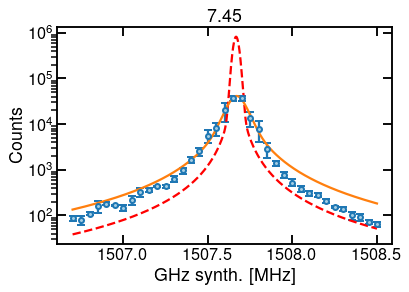

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 37
    # variables        = 4
    chi-square         = 27431246.4
    reduced chi-square = 831249.891
    Akaike info crit   = 508.102189
    Bayesian info crit = 514.545861
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.53690863 +/- 0.08455366 (15.75%) (init = 0.15)
    mF112_sigma:      0.07867603 +/- 0.00237804 (3.02%) (init = 0.02)
    mF112_center:     1507.68310 +/- 0.00146752 (0.00%) (init = 1507.667)
    mF112_amplitude:  8248.88682 +/- 241.048491 (2.92%) (init = 41424)
    mF112_fwhm:       0.15735206 +/- 0.00475608 (3.02%) == '2.0000000*mF112_sigma'
    mF112_height:     40725.0074 +/- 828.436354 (2.03%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are <

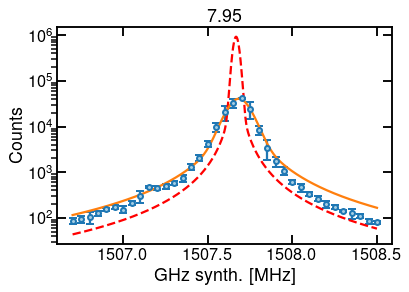

[[Model]]
    (Model(constant, prefix='bg_') + Model(pvoigt, prefix='mF112_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 37
    # variables        = 4
    chi-square         = 37528907.8
    reduced chi-square = 1137239.63
    Akaike info crit   = 519.699054
    Bayesian info crit = 526.142725
[[Variables]]
    bg_c:             1 (fixed)
    mF112_fraction:   0.21582135 +/- 0.11615986 (53.82%) (init = 0.15)
    mF112_sigma:      0.09388289 +/- 0.00278541 (2.97%) (init = 0.02)
    mF112_center:     1507.65954 +/- 0.00193634 (0.00%) (init = 1507.667)
    mF112_amplitude:  8142.40928 +/- 309.752506 (3.80%) (init = 35285)
    mF112_fwhm:       0.18776578 +/- 0.00557082 (2.97%) == '2.0000000*mF112_sigma'
    mF112_height:     37904.3497 +/- 841.204654 (2.22%) == '(((1-mF112_fraction)*mF112_amplitude)/(mF112_sigma*sqrt(pi/log(2)))+(mF112_fraction*mF112_amplitude)/(pi*mF112_sigma))'
[[Correlations]] (unreported correlations are <

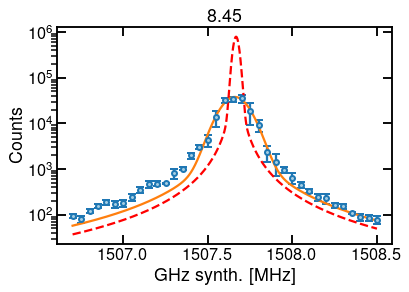

In [33]:
def fit_spectra(x, y, yerr, name):
    # Specify fit model
    bg = ConstantModel(prefix='bg_')
    mF112 = PseudoVoigtModel(prefix='mF112_')
    #mF92 = PseudoVoigtModel(prefix='mF92_')
    #mF72 = PseudoVoigtModel(prefix='mF72_')
    #mF52 = GaussianModel(prefix='mF52_')
    #mF32 = GaussianModel(prefix='mF32_')
    
    #fit_model = bg + mF112 + mF92 + mF72 + mF52 + mF32
    fit_model = bg + mF112
    fit_params = fit_model.make_params()
    
    mF112_center = 1507.66680;
    zeeman_shift = 1507.66680  - 1507.41407;
    #mF92_center = mF112_center - 1*zeeman_shift
    #mF72_center = mF112_center - 2*zeeman_shift
    #mF52_center = mF112_center - 3*zeeman_shift
    #mF32_center = mF112_center - 4*zeeman_shift
    
    # Set initial guesses
    #fit_params['bg_c'].set(2, min=0, max=10, vary=False)
    fit_params['bg_c'].set(1, min=0, vary=False)
    
    fit_params['mF112_center'].set(mF112_center, min=mF112_center-zeeman_shift/3, max=mF112_center+zeeman_shift/3, vary=True)
    fit_params['mF112_amplitude'].set(max(y), min=0, vary=True)
    fit_params['mF112_sigma'].set(0.02, min=0.005, vary=True)
    fit_params['mF112_fraction'].set(0.15, vary=True)
    
    #fit_params['mF92_center'].set(mF92_center, min=mF92_center-zeeman_shift/3, max=mF92_center+zeeman_shift/3, vary=True)
    #fit_params['mF92_amplitude'].set(max(y)/1E3, min=0, vary=True)
    #fit_params['mF92_sigma'].set(0.02, min=0.01, max=0.1, vary=True)
    
    #fit_params['mF72_center'].set(mF72_center, min=mF72_center-zeeman_shift/3, max=mF72_center+zeeman_shift/3, vary=True)
    #fit_params['mF72_amplitude'].set(max(y)/1E4, min=0, vary=True)
    #fit_params['mF72_sigma'].set(0.04, min=0.01, max=0.1, vary=True)
    
    #fit_params['mF52_center'].set(mF52_center, min=mF52_center-zeeman_shift/3, max=mF52_center+zeeman_shift/3)
    #fit_params['mF52_amplitude'].set(max(y)/1E4, min=0)
    #fit_params['mF52_sigma'].set(0.04, min=0.01, max=0.1)
    
    #fit_params['mF32_center'].set(mF32_center, min=mF32_center-zeeman_shift/3, max=mF32_center+zeeman_shift/3)
    #fit_params['mF32_amplitude'].set(max(y)/1E4, min=0)
    #fit_params['mF32_sigma'].set(0.04, min=0.01, max=0.1)

    # Initial guess
    xfit = xfit = np.linspace(min(x), max(x), num=1000, endpoint=True)
    yinit = fit_model.eval(fit_params, x=xfit)

    # Fitting
    fit_result = fit_model.fit(y, fit_params, x=x)
    dely = fit_result.eval_uncertainty(x=x)
    yfit = fit_model.eval(fit_result.params, x=xfit)
    
    print(fit_result.fit_report())
    
    # Plot fitted result
    plt.figure()
    
    plt.gca().set_yscale('log')
    
    # Plot data
    plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=4, markeredgewidth=2, markersize=5,
                 markeredgecolor=sns.color_palette("Paired")[1], markerfacecolor=sns.color_palette("Paired")[0])

    # Plot initial guess
    plt.plot(xfit, yinit, '--', color='red')

    # Plot fitted result
    plt.plot(xfit, yfit)
    
    plt.gca().tick_params(direction='in', axis='both', bottom=True, top=True, left=True, right=True)
    plt.title(name)
    
    plt.xlabel('GHz synth. [MHz]')
    plt.ylabel('Counts')
    
    plt.show()
    
    return fit_result

vary_UV_data_fit_results = pd.DataFrame(columns=(('UV_VCA',''),
                                                 ('UV_Power','mean'), ('UV_Power','std'),
                                                 ('Spec_Power','mean'), ('Spec_Power','std'),
                                                 ('height','mean'), ('height', 'std')))


for key, group in vary_UV_data.groupby(by=['UV_VCA [V]'], as_index=False):
    UV_VCA_group = group.groupby(by=['GHz_Synth'], as_index=False).agg({'sfiIntegral':[np.mean, np.std],
                                                                        'UV_Power':[np.mean, np.std],
                                                                        'Spec_Power':[np.mean, np.std],
                                                                        'numberAtom':[np.mean, np.std],
                                                                        'tempXAtom':[np.mean, np.std],
                                                                        'tempYAtom':[np.mean, np.std]})
    
    xdata = UV_VCA_group['GHz_Synth']
    ydata = UV_VCA_group['sfiIntegral','mean']
    yerr = yerr=UV_VCA_group['sfiIntegral','std']
    
    fit_results = fit_spectra(xdata, ydata, yerr, key)
    
    UV_Power_mean = np.mean(UV_VCA_group['UV_Power','mean'])
    UV_Power_std = np.std(UV_VCA_group['UV_Power','mean'])
    Spec_power_mean = np.mean(UV_VCA_group['Spec_Power','mean'])
    Spec_power_std = np.std(UV_VCA_group['Spec_Power','mean'])
    height_mean = fit_results.params['mF112_height'].value
    height_std = fit_results.params['mF112_height'].stderr
    
    temp = pd.DataFrame(data=[[key, UV_Power_mean, UV_Power_std, Spec_power_mean, Spec_power_std, height_mean, height_std]],
                        columns=(('UV_VCA',''),
                                 ('UV_Power','mean'), ('UV_Power','std'),
                                 ('Spec_Power','mean'), ('Spec_Power','std'),
                                 ('height','mean'), ('height', 'std')))
    
    vary_UV_data_fit_results = vary_UV_data_fit_results.append(temp, ignore_index=True)

# To get counts/exposure, divide by 1000 since we used 1000 loops
vary_UV_data_fit_results['counts_per_exposure','mean'] = vary_UV_data_fit_results['height','mean']/1000
vary_UV_data_fit_results['counts_per_exposure','std'] = vary_UV_data_fit_results['height','std']/1000

In [34]:
# Convert UV_Power DAQ voltage to [mW] using conversion_slope and conversion_intercept

UV_Power_DAQ = unumpy.uarray(vary_UV_data_fit_results['UV_Power','mean'], vary_UV_data_fit_results['UV_Power','std'])
UV_Power_mW = conversion_slope*UV_Power_DAQ + conversion_intercept

vary_UV_data_fit_results['UV_Power_mW','mean'] = unumpy.nominal_values(UV_Power_mW)
vary_UV_data_fit_results['UV_Power_mW','std'] = unumpy.std_devs(UV_Power_mW)

In [35]:
xdata = vary_UV_data_fit_results['UV_Power_mW','mean']
ydata = vary_UV_data_fit_results['counts_per_exposure','mean']

def mcp_saturation(x, a, b):
    return a*(1 - np.exp(b*(x)))

fit_model = Model(mcp_saturation)
fit_result = fit_model.fit(ydata, x=xdata, a=40, b=-0.1)
dely = fit_result.eval_uncertainty(x=x)
print(fit_result.fit_report())

saturation_a = ufloat(fit_result.params['a'].value, fit_result.params['a'].stderr)
saturation_b = ufloat(fit_result.params['b'].value, fit_result.params['b'].stderr)

[[Model]]
    Model(mcp_saturation)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 26
    # variables        = 2
    chi-square         = 67.3408471
    reduced chi-square = 2.80586863
    Akaike info crit   = 28.7434318
    Bayesian info crit = 31.2596249
[[Variables]]
    a:  44.0442577 +/- 1.65367228 (3.75%) (init = 40)
    b: -0.05852894 +/- 0.00456716 (7.80%) (init = -0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.939



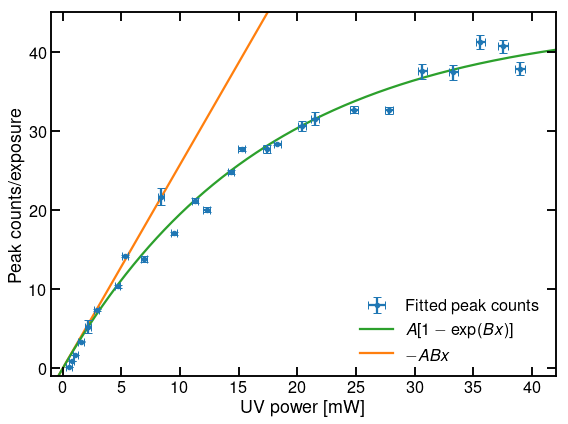

In [36]:
plt.figure(figsize=(8,6))

data_pnts = plt.errorbar(vary_UV_data_fit_results['UV_Power_mW','mean'], vary_UV_data_fit_results['counts_per_exposure','mean'],
                         xerr=vary_UV_data_fit_results['UV_Power_mW','std'], yerr=vary_UV_data_fit_results['counts_per_exposure','std'],
                         capsize=4, fmt='.', label=r'Fitted peak counts', zorder=2)

x = np.linspace(-10,50,1000)
y = -saturation_a.nominal_value*saturation_b.nominal_value*x
linearized_model = plt.plot(x, y, label=r'$-A B x$', zorder=0)

x = np.linspace(-10,50,1000)
y = mcp_saturation(x, saturation_a.nominal_value, saturation_b.nominal_value)
empirical_model = plt.plot(x, y, label=r'$A \qty[1-\exp(B x)]$', zorder=1)

plt.xlabel(r'UV power [mW]')
plt.ylabel(r'Peak counts/exposure')
plt.gca().tick_params(direction='in', axis='both', bottom=True, top=True, left=True, right=True)
plt.xlim(-1, 42)
plt.ylim(-1, 45)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower right', frameon=False)

plt.tight_layout()

plt.savefig('mcp-counts_vs_uv_power.pdf', bbox_inches='tight')
plt.savefig('mcp-counts_vs_uv_power.png', bbox_inches='tight', transparent=True, dpi=1000)

plt.show()

In [15]:
print(saturation_a)
print(saturation_b)

44.0+/-1.7
-0.059+/-0.005


# MCP saturation varying 689 nm power (constant UV power)

In [16]:
saturation_a.nominal_value

44.04425771561097